In [1]:
import pandas as pd 
import pickle 
import os 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

pd.options.display.float_format = '{:.6f}'.format

os.chdir("/Users/gsgeiger/norwegian_lay_judges/scratchpad/drunk_driving/")


### Load and merge data

In [2]:
with open("processed_data/processed_drunk_driving.pickle","rb") as f : 
    df_manual = pickle.load(f)
    f.close()

print("Data loaded with shape",df_manual.shape)

Data loaded with shape (278, 261)


In [3]:
with open("processed_data/gpt_drunk_driving.pickle","rb") as f : 
    df_gpt = pickle.load(f)
    f.close()

print("Data loaded with shape",df_gpt.shape)

Data loaded with shape (271, 13)


In [4]:
df = pd.merge(df_manual, df_gpt, how='left',on='_id')

### Load configs 

In [5]:
aggravting_mitigating_circumstances = pd.read_excel('config/aggravating_mitigating_circs.xlsx')['col'].to_list()

# Filter so we only have aggravating and mitigating circumstances in our df
aggravting_mitigating_circumstances = [
    circumstance for circumstance in aggravting_mitigating_circumstances if circumstance in df.columns
]

# Relevant criminal sections
criminal_sections = list(df.filter(like='convicted_').columns)

# Heavily correlated with main conviction sections
criminal_sections.remove("convicted_section_24_of_the_medicines_act_other")
criminal_sections.remove("chapter_convicted_section_24_of_the_medicines_act")

fixed_sections = []
for section in criminal_sections : 
    if "." in section : 
        fixed_section = section.replace(".","_")
        fixed_sections.append(fixed_section)
    
    else : 
        fixed_sections.append(section)

criminal_sections = fixed_sections

# Defendant demographics 
defendant_chars = pd.read_excel('config/config_regression.xlsx')['vars'].to_list()

# Judge characteristics 
judge_chars =  pd.read_excel('config/config_regression.xlsx',sheet_name='judge_chars')['vars'].to_list()
# print("Judge characteristics:",judge_chars[:10])

# Outcomes 
outcomes = ['punishment_prison_days']
# outcomes = pd.read_excel('00_raw_data/config_regression.xlsx',sheet_name='outcomes')['vars'].to_list()

# Crime specific 
crime_specific = list(df.filter(like='drug_found').columns)
crime_specific = crime_specific + ["bpa_High","n_dui_incidents",'past_dui_considered']

vars_to_check = defendant_chars + crime_specific + criminal_sections + aggravting_mitigating_circumstances + judge_chars

print(vars_to_check)

['defendant_age', 'defendant_is_woman', 'defendant_some_foreign_background', 'defendant_log_net_income', 'case_is_not_oslo', 'defendant_is_married', 'drug_found_alprazolam', 'drug_found_amfetamin', 'drug_found_thc', 'drug_found_ghb', 'drug_found_diazepam', 'drug_found_valium', 'drug_found_kokain', 'bpa_High', 'n_dui_incidents', 'past_dui_considered', 'convicted_drug_offense', 'convicted_drinking_within_six_hours_of_traffic_investigation', 'convicted_sentencing_beyond_the_maximum_sentence__multiple_offences_repeat_offences_organized_crime_', 'convicted_temporary_suspension_of_driving_lisence', 'convicted_violating_basic_traffic_rules', 'convicted_loss_of_the_right_to_drive_a_motor_vehicle_', 'group1_mitigating_confession', 'group1_aggravating_other', 'group1_aggravating_repeated_offense', 'group1_aggravating_driving', 'group1_mitigating_processing_time', 'group1_aggravating_life_health', 'group1_mitigating_other', 'group1_aggravating_severe', 'group1_aggravating_cumulative_offense', 'gr

### Fix columns with periods that will mess up regression

In [6]:
fixed_columns = {}
for col in df.columns : 
    if "." in col : 
        fixed_col = col.replace(".","_")
        fixed_columns[col] = fixed_col

df.rename(columns=fixed_columns,inplace=True)

### Descriptive

### Create chart for methodology

In [7]:
df_chart = df.copy()

df_chart['bpa_group'] = df_chart['bpa_group'].replace({'High' : '>1.2', 'Medium' : 'Between 0.5 and 1.2', 'Low':'<0.5'})

df_chart_crosstab = pd.crosstab(df_chart['defendant_net_income_quantile'], df_chart['bpa_group'],margins=True)

df_chart_crosstab.to_excel('../../03_results/chart_data/bpa_table.xlsx')


### Create chart data for prison sentence length by income qunatile

In [8]:
df_chart = df.copy()

df_chart = df_chart.groupby('defendant_net_income_quantile')['punishment_prison_days'].mean()
df_chart = df_chart.reset_index()

df_chart = df_chart.rename(columns = {'defendant_net_income_quantile' : 'Net Income Quantile', 'punishment_prison_days' : 'Average prison sentence (days)'})

df_chart.to_excel('../../03_results/chart_data/dui_average_prison_sentences.xlsx')


### Create chart for conditional prison sentences by income qunatile

In [9]:
df_chart = df.copy()

df_chart = df_chart[df_chart['bpa_group'] == 'High']


df_chart['punishment_conditional'] = df['punishment_conditional'].apply(
    lambda conditional : 'Probationary sentence' if conditional == 'true' else 'Unconditional sentence')

crosstab = pd.crosstab(df_chart['defendant_net_income_quantile'], df_chart['punishment_conditional'])

crosstab.to_excel('../../03_results/chart_data/bpa_conditional.xlsx')


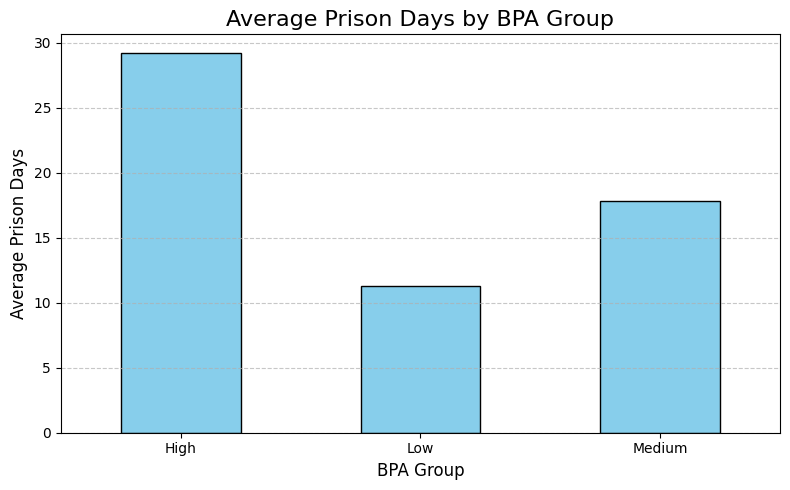

In [10]:
avg_prison_days = df.groupby('bpa_group')['punishment_prison_days'].mean()

plt.figure(figsize=(8, 5))
avg_prison_days.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Average Prison Days by BPA Group', fontsize=16)
plt.xlabel('BPA Group', fontsize=12)
plt.ylabel('Average Prison Days', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Create table data for BPA group by income quanntile 

In [11]:
pd.crosstab(df['defendant_net_income_quantile'],df['bpa_group'])

bpa_group,High,Low,Medium
defendant_net_income_quantile,,,
1,24,1,19
2,36,1,41
3,46,0,33
4,42,2,37


### Generic function for running regressions 

In [17]:

def run_regression_model(df : pd.DataFrame, outcome : str) -> pd.DataFrame : 

    formula = f"{outcome} ~ {' + '.join(vars_to_check)}"

    cur_fit = smf.ols(formula=formula, data=df).fit()

    model_fit_df = pd.DataFrame({
        "term": cur_fit.params.index,
        "estimate": cur_fit.params.values,
        "std_error": cur_fit.bse.values,
        "p_value": cur_fit.pvalues.values,
        "conf_low": cur_fit.conf_int().iloc[:, 0],
        "conf_high": cur_fit.conf_int().iloc[:, 1]
    })

    model_fit_df["sig_level"] = np.select(
        [
            model_fit_df["p_value"] < 0.01,
            model_fit_df["p_value"] < 0.05,
            model_fit_df["p_value"] < 0.1
        ],
        ["***", "**", "*"],
        default="insig"
    )

    return model_fit_df




### Run regression model for all sentences

In [18]:
model_all_sentences = run_regression_model(df, "punishment_prison_days")
model_all_sentences['model_spec'] = 'convictions'

model_all_sentences[model_all_sentences['sig_level'] != 'insig']

,term,estimate,std_error,p_value,conf_low,conf_high,sig_level,model_spec
defendant_age,defendant_age,0.366270,0.210221,0.083039,-0.048342,0.780881,*,convictions
defendant_log_net_income,defendant_log_net_income,-1.739582,0.554792,0.001982,-2.833781,-0.645383,***,convictions
bpa_High,bpa_High,13.323393,4.693832,0.005015,4.065901,22.580886,***,convictions
n_dui_incidents,n_dui_incidents,7.544951,3.053410,0.014336,1.522809,13.567093,**,convictions
past_dui_considered,past_dui_considered,12.921760,4.801745,0.007744,3.451434,22.392086,***,convictions
group1_mitigating_processing_time,group1_mitigating_processing_time,10.506560,6.010206,0.082025,-1.347173,22.360294,*,convictions
group1_mitigating_other,group1_mitigating_other,-18.523910,10.576420,0.081451,-39.383441,2.335620,*,convictions
judge_age,judge_age,-0.508331,0.211218,0.017036,-0.924909,-0.091754,**,convictions
judge_is_married,judge_is_married,8.470642,4.564137,0.064983,-0.531058,17.472341,*,convictions


### Run model for just prison sentences

In [19]:
df_prison_days_only = df[df['punishment_prison_days'] > 0]

model_prison_days_only = run_regression_model(df_prison_days_only, 'punishment_prison_days')
model_prison_days_only['model_spec'] = 'prison_days_only'

model_prison_days_only[model_prison_days_only['sig_level'] != 'insig']

,term,estimate,std_error,p_value,conf_low,conf_high,sig_level,model_spec
defendant_log_net_income,defendant_log_net_income,-1.749919,0.741944,0.020197,-3.221057,-0.278781,**,prison_days_only
drug_found_amfetamin,drug_found_amfetamin,15.973931,7.707284,0.040661,0.691810,31.256051,**,prison_days_only
n_dui_incidents,n_dui_incidents,9.225326,4.227873,0.031337,0.842235,17.608416,**,prison_days_only
past_dui_considered,past_dui_considered,15.508062,7.425506,0.039172,0.784656,30.231469,**,prison_days_only
group1_mitigating_processing_time,group1_mitigating_processing_time,16.274223,8.925763,0.071105,-1.423915,33.972361,*,prison_days_only
judge_age,judge_age,-0.570110,0.335254,0.091991,-1.234856,0.094636,*,prison_days_only
judge_is_married,judge_is_married,12.503709,6.707029,0.065077,-0.795089,25.802508,*,prison_days_only


### Run model for logged prison sentence

In [20]:
df_prison_days_only['prison_days_log'] = np.log(df_prison_days_only['punishment_prison_days'])

model_prison_log = run_regression_model(df_prison_days_only, "prison_days_log")
model_prison_log['model_spec'] = 'prison_days_logged'

model_prison_log[model_prison_log['sig_level'] != 'insig']

/var/folders/hp/kn6pmy_14nv6djdz1m3qrg200000gn/T/ipykernel_53832/154656130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prison_days_only['prison_days_log'] = np.log(df_prison_days_only['punishment_prison_days'])


,term,estimate,std_error,p_value,conf_low,conf_high,sig_level,model_spec
defendant_log_net_income,defendant_log_net_income,-0.023653,0.010209,0.022451,-0.043896,-0.003411,**,prison_days_logged
drug_found_amfetamin,drug_found_amfetamin,0.206519,0.106051,0.054163,-0.003761,0.416799,*,prison_days_logged
n_dui_incidents,n_dui_incidents,0.207568,0.058175,0.000544,0.092217,0.322918,***,prison_days_logged
past_dui_considered,past_dui_considered,0.351509,0.102174,0.000835,0.148917,0.554102,***,prison_days_logged
group1_aggravating_other,group1_aggravating_other,-0.222670,0.104018,0.034613,-0.428918,-0.016422,**,prison_days_logged
group1_aggravating_drugs,group1_aggravating_drugs,-0.196045,0.114810,0.090673,-0.423691,0.031602,*,prison_days_logged


### Run negative binomial model

In [21]:

formula = f"{'punishment_prison_days'} ~ {' + '.join(vars_to_check)}"

fit_negative_binomial = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit()

model_fit_df = pd.DataFrame({
        "term": fit_negative_binomial.params.index,
        "estimate": fit_negative_binomial.params.values,
        "std_error": fit_negative_binomial.bse.values,
        "p_value": fit_negative_binomial.pvalues.values,
        "conf_low": fit_negative_binomial.conf_int().iloc[:, 0],
        "conf_high": fit_negative_binomial.conf_int().iloc[:, 1]
    })

model_fit_df["sig_level"] = np.select(
    [
        model_fit_df["p_value"] < 0.01,
        model_fit_df["p_value"] < 0.05,
        model_fit_df["p_value"] < 0.1
    ],
    ["***", "**", "*"],
    default="insig"
)

model_fit_df['model_spec'] = 'negative_binomial'

model_fit_df[model_fit_df['sig_level'] != 'insig']

/opt/homebrew/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,term,estimate,std_error,p_value,conf_low,conf_high,sig_level,model_spec
defendant_age,defendant_age,0.029410,0.007145,0.000039,0.015406,0.043414,***,negative_binomial
defendant_some_foreign_background,defendant_some_foreign_background,-0.352344,0.197480,0.074391,-0.739398,0.034710,*,negative_binomial
defendant_log_net_income,defendant_log_net_income,-0.066054,0.018585,0.000379,-0.102481,-0.029628,***,negative_binomial
defendant_is_married,defendant_is_married,0.946783,0.369849,0.010470,0.221893,1.671673,**,negative_binomial
drug_found_thc,drug_found_thc,-0.400139,0.164779,0.015168,-0.723101,-0.077178,**,negative_binomial
bpa_High,bpa_High,0.959120,0.159630,0.000000,0.646250,1.271990,***,negative_binomial
n_dui_incidents,n_dui_incidents,0.303941,0.102759,0.003098,0.102538,0.505344,***,negative_binomial
past_dui_considered,past_dui_considered,0.549247,0.164748,0.000857,0.226346,0.872148,***,negative_binomial
convicted_sentencing_beyond_the_maximum_sentence__multiple_offences_repeat_offences_organized_crime_,convicted_sentencing_beyond_the_maximum_senten...,0.655784,0.160200,0.000042,0.341798,0.969770,***,negative_binomial
convicted_violating_basic_traffic_rules,convicted_violating_basic_traffic_rules,-0.707230,0.331207,0.032735,-1.356383,-0.058077,**,negative_binomial
